In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def resnet18(num_classes, in_channels=1):
    '''稍加修改的ResNet-18模型'''
    def resnet_block(in_channels, out_channels, num_residuals,first_block=False):
        blk=[]
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels,out_channels))
        return nn.Sequential(*blk)
    
    #该模型使用了更小的卷积核，步长和填充，而且删除了最大池化层
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU())
    net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
    net.add_module("resnet_block2", resnet_block(64, 128, 2))
    net.add_module("resnet_block3", resnet_block(128, 256, 2))
    net.add_module("resnet_block4", resnet_block(256, 512, 2))
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
    net.add_module("fc", nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, num_classes)))
    return net

In [4]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
# 我们将在训练代码实现中初始化网络


用于训练的代码需要执行几个基本功能才能实现高效并行：

需要在所有设备上初始化网络参数。

在数据集上迭代时，要将小批量数据分配到所有设备上。

跨设备并行计算损失及其梯度。

聚合梯度，并相应地更新参数。

最后，并行地计算精确度和发布网络的最终性能

In [5]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个 GPU 上设置模型
    net = nn.DataParallel(net, device_ids=devices)#给定一个net，给定device，返回一个新的net 
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

test acc: 0.92, 33.8 sec/epoch on [device(type='cuda', index=0)]


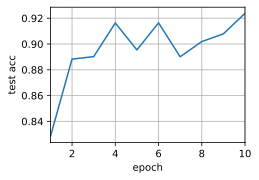

In [6]:
train(net, num_gpus=1, batch_size=256, lr=0.1)

In [6]:
train(net,num_gpus=2,batch_size=256, lr=0.1)#多GPU运行

/home/wyr/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


ValueError: Expected a non cpu device, but got: cpu